Explicit Option Price: 5.635127538545092


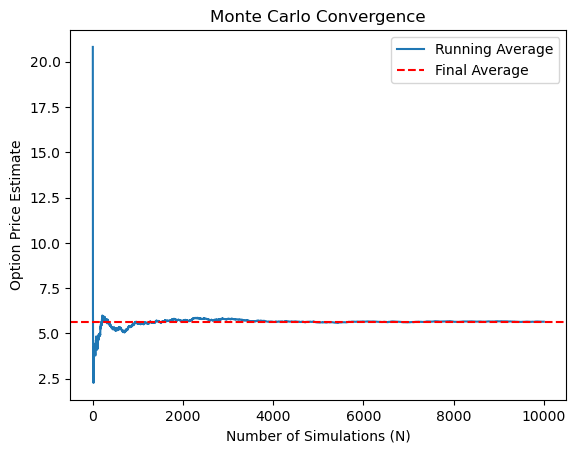

Monte Carlo Option Price: 5.649772311461602
Explicit Option Price: 5.635127538545092


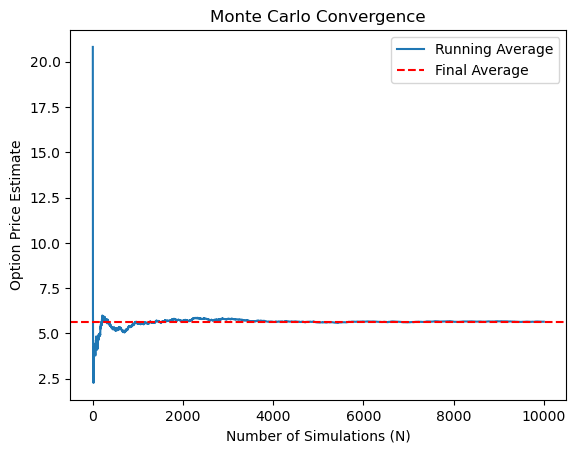

Monte Carlo Option Price: 5.649772311461602

Delta Matrix:
[[0.53731286 0.59274069 0.64708631 ... 1.         1.         0.        ]
 [0.         0.50875913 0.56474446 ... 1.         1.         0.        ]
 [0.         0.         0.47991821 ... 1.         1.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]


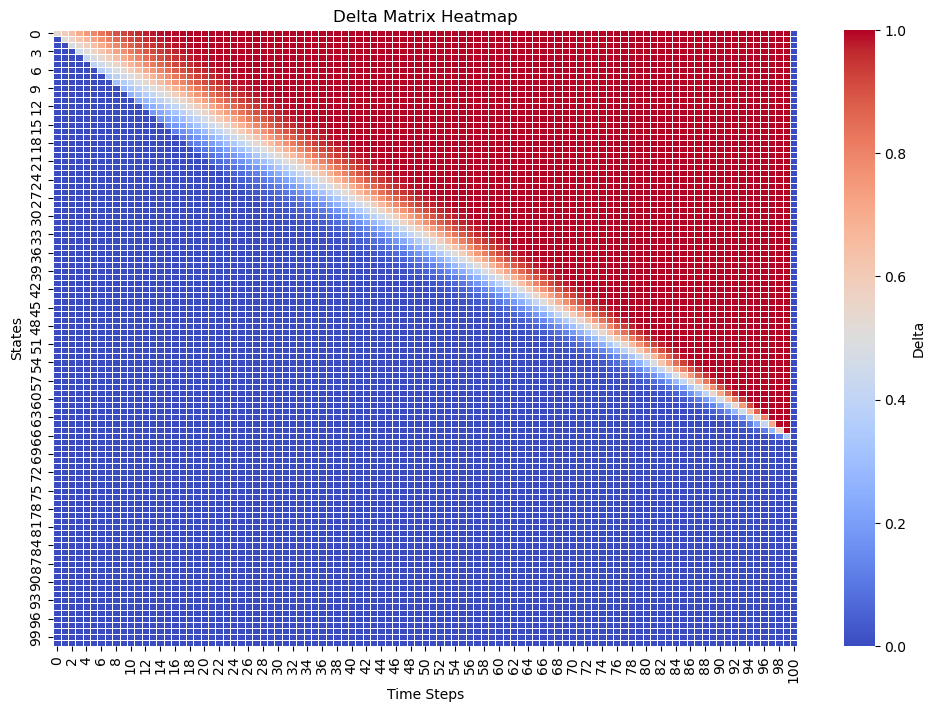

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Explicit Binomial Tree Method
def explicit_binomial_call(T, S, Ru, Rd, K):
    # Set the risk-free rate to zero as per the exercise requirements
    r = 0.00  # Interest rate is zero
    delta_t = 1 / T  # Time step
    
    # Calculate the risk-neutral probability with zero interest rate
    p = (1 - Rd) / (Ru - Rd)
    
    # Step 1: Initialize stock price matrix
    stock_price = np.zeros((T + 1, T + 1))
    stock_price[0, 0] = S
    
    # Generate the stock price tree
    for t in range(1, T + 1):
        for i in range(t + 1):
            stock_price[i, t] = S * (Ru ** (t - i)) * (Rd ** i)
    
    # Step 2: Initialize option price matrix
    option_price = np.zeros((T + 1, T + 1))
    for i in range(T + 1):
        option_price[i, T] = max(stock_price[i, T] - K, 0)
    
    # Step 3: Backward induction for option prices
    for t in range(T - 1, -1, -1):
        for i in range(t + 1):
            option_price[i, t] = p * option_price[i, t + 1] + (1 - p) * option_price[i + 1, t + 1]
    
    return stock_price, option_price, option_price[0, 0]


# Monte Carlo Simulation Method (with risk-neutral probabilities)
def monte_carlo_call(T, S, Ru, Rd, K, N):
    """
    Estimates the option price using Monte Carlo simulation.

    Parameters:
    - T: int, number of time steps
    - S: float, initial stock price
    - Ru: float, up factor
    - Rd: float, down factor
    - K: float, strike price
    - N: int, number of simulations

    Returns:
    - float, Monte Carlo estimate of the option price
    """
    np.random.seed(132)  # For reproducibility
    final_values = []
    
    # Calculate the risk-neutral probability
    p = (1 - Rd) / (Ru - Rd)
    
    for _ in range(N):
        price = S
        for _ in range(T):
            price *= Ru if np.random.rand() < p else Rd  # Use risk-neutral probability
        final_values.append(max(price - K, 0))
    
    # Running average of final values
    running_avg = np.cumsum(final_values) / np.arange(1, N + 1)
    
    # Plot running average
    plt.plot(range(1, N + 1), running_avg, label='Running Average')
    plt.axhline(y=running_avg[-1], color='r', linestyle='--', label='Final Average')
    plt.xlabel('Number of Simulations (N)')
    plt.ylabel('Option Price Estimate')
    plt.title('Monte Carlo Convergence')
    plt.legend()
    plt.show()
    
    return running_avg[-1]

# Parameters
T = 100
S = 100
Ru = 1.02
Rd = 0.99
K = 100
N = 10000

# Explicit Method
stock_matrix, option_matrix, explicit_price = explicit_binomial_call(T, S, Ru, Rd, K)
print(f"Explicit Option Price: {explicit_price}")

# Monte Carlo Method
monte_carlo_price = monte_carlo_call(T, S, Ru, Rd, K, N)
print(f"Monte Carlo Option Price: {monte_carlo_price}")


# Calculate Deltas
def calculate_deltas(stock_price, option_price, T):
    """
    Calculates delta values for a binomial tree.

    Parameters:
    - stock_price: 2D numpy array of stock prices
    - option_price: 2D numpy array of option prices
    - T: int, number of time steps

    Returns:
    - deltas: 2D numpy array of delta values
    """
    deltas = np.zeros((T + 1, T + 1))
    for t in range(T):
        for i in range(t + 1):
            # Retrieve stock prices for up and down states
            Su = stock_price[i, t + 1]
            Sd = stock_price[i + 1, t + 1]

            # Retrieve option prices for up and down states
            Vu = option_price[i, t + 1]
            Vd = option_price[i + 1, t + 1]

            # Safeguard to avoid division by zero
            if Su != Sd:
                deltas[i, t] = (Vu - Vd) / (Su - Sd)
            else:
                deltas[i, t] = 0  # Default to 0 if no price movement occurs

    return deltas


# Parameters
T = 100
S = 100
Ru = 1.02
Rd = 0.99
K = 100
N = 10000

# Explicit Method
stock_matrix, option_matrix, explicit_price = explicit_binomial_call(T, S, Ru, Rd, K)
print(f"Explicit Option Price: {explicit_price}")

# Monte Carlo Method
monte_carlo_price = monte_carlo_call(T, S, Ru, Rd, K, N)
print(f"Monte Carlo Option Price: {monte_carlo_price}")

# Calculate and Display Delta Matrix
deltas = calculate_deltas(stock_matrix, option_matrix, T)
print("\nDelta Matrix:")
print(deltas)

# Heatmap of Delta Values
import seaborn as sns

plt.figure(figsize=(12, 8))
sns.heatmap(
    deltas, 
    annot=False, 
    cmap="coolwarm", 
    cbar_kws={"label": "Delta"},
    linewidths=0.5
)
plt.title("Delta Matrix Heatmap")
plt.xlabel("Time Steps")
plt.ylabel("States")
plt.show()


In [2]:

def hedging_portfolio_simulation(T, S, Ru, Rd, K, rebalance_period=1):
    """
    Simulates a hedging portfolio for a call option using a binomial tree model.
    
    Parameters:
    - T: int, number of time steps
    - S: float, initial stock price
    - Ru: float, stock up factor
    - Rd: float, stock down factor
    - K: float, strike price
    - rebalance_period: int, frequency of rebalancing
    
    Returns:
    - stock_price_path: list, simulated stock prices over time
    - portfolio_value_path: list, hedging portfolio values over time
    - option_value_path: list, option values over time
    - tracking_error: list, difference between portfolio value and option value over time
    """
    # Generate the stock price tree, option price tree, and deltas
    stock_price_matrix, option_price_matrix, option_price_at_t0 = explicit_binomial_call(T, S, Ru, Rd, K)
    delta_matrix = calculate_deltas(stock_price_matrix, option_price_matrix, T)

    # Initialize variables
    stock_price_path = [S]
    portfolio_value_path = []
    option_value_path = [option_price_at_t0]  # Add initial option value at t=0
    tracking_error = []

    # Set up the initial delta and cash account
    delta = delta_matrix[0, 0]
    cash_account = option_price_at_t0 - delta * S  # Initial cash balance to match option price
    portfolio_value = delta * S + cash_account

    # Record values at t=0
    portfolio_value_path.append(portfolio_value)
    tracking_error.append(portfolio_value - option_price_at_t0)

    for t in range(1, T + 1):
        current_stock_price = stock_price_path[-1]

        # Rebalance portfolio every `rebalance_period`
        if t % rebalance_period == 0:
            new_delta = delta_matrix[0, t]
            cash_account += (delta - new_delta) * current_stock_price  # Update cash account for rebalancing
            delta = new_delta

        # Update portfolio value
        portfolio_value = delta * current_stock_price + cash_account

        # Record values
        portfolio_value_path.append(portfolio_value)
        option_value_path.append(option_price_matrix[0, t])  # Add option value at this time step
        tracking_error.append(portfolio_value - option_price_matrix[0, t])

        # Simulate next stock price
        next_stock_price = current_stock_price * (Ru if np.random.rand() < 0.5 else Rd)
        stock_price_path.append(next_stock_price)

        # Debugging output
        print(
            f"Time {t}: Stock Price = {current_stock_price}, Delta = {delta}, "
            f"Portfolio Value = {portfolio_value}, Cash Account = {cash_account}"
        )

    # Plot stock price, option value, and portfolio value
    plt.figure(figsize=(10, 6))
    plt.plot(range(T + 1), stock_price_path, label="Stock Price Path", linestyle="--")
    plt.plot(range(T + 1), option_value_path, label="Option Value Path", linestyle="-")  # Fixed length
    plt.plot(range(T + 1), portfolio_value_path, label="Hedging Portfolio Value", linestyle=":")
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.title(f"Hedging Portfolio Simulation (Rebalance Every {rebalance_period} Periods)")
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.7)
    plt.show()

    # Plot tracking error
    plt.figure(figsize=(10, 6))
    plt.plot(range(T + 1), tracking_error, label="Tracking Error", color="purple")  # Fixed length
    plt.xlabel("Time")
    plt.ylabel("Tracking Error")
    plt.title("Tracking Error Over Time")
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.7)
    plt.show()

    return stock_price_path, portfolio_value_path, option_value_path, tracking_error


Time 1: Stock Price = 100, Delta = 0.5927406881378016, Portfolio Value = 5.635127538545092, Cash Account = -53.63894127523506
Time 2: Stock Price = 99.0, Delta = 0.6470863057138314, Portfolio Value = 5.042386850407297, Cash Account = -59.019157415262015
Time 3: Stock Price = 100.98, Delta = 0.6992834960891728, Portfolio Value = 6.323617735720674, Cash Account = -64.290029699364
Time 4: Stock Price = 102.9996, Delta = 0.7483512933768547, Portfolio Value = 7.7358906844223725, Cash Account = -69.34399319287631
Time 5: Stock Price = 105.05959200000001, Delta = 0.7934544424305393, Portfolio Value = 9.277488361968352, Cash Account = -74.0825116303716
Time 6: Stock Price = 104.00899608, Delta = 0.8339532623533803, Portfolio Value = 8.443888362044959, Cash Account = -78.29475323297099
Time 7: Stock Price = 102.9689061192, Delta = 0.8694374211903472, Portfolio Value = 7.576501946094794, Cash Account = -81.94851825297341
Time 8: Stock Price = 101.939217058008, Delta = 0.899739901884679, Portfoli

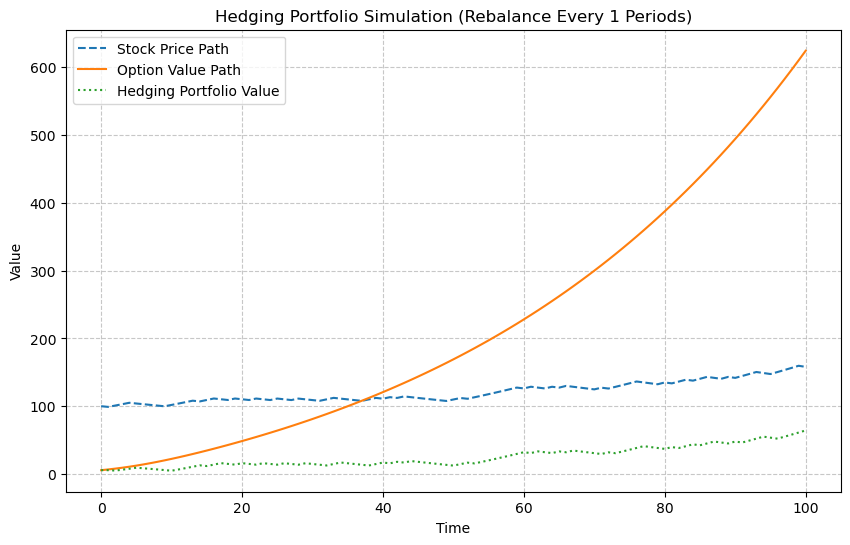

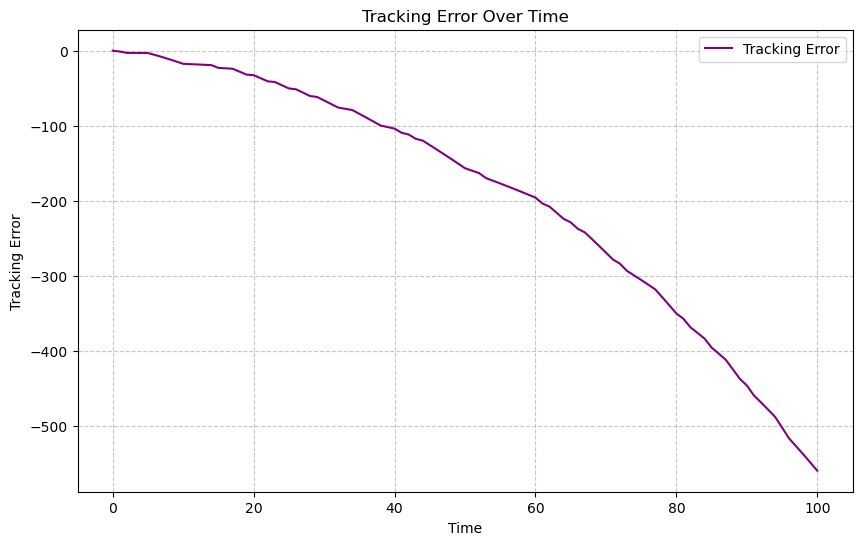

([100,
  99.0,
  100.98,
  102.9996,
  105.05959200000001,
  104.00899608,
  102.9689061192,
  101.939217058008,
  100.91982488742792,
  99.91062663855364,
  101.90883917132471,
  103.94701595475121,
  106.02595627384623,
  108.14647539932317,
  107.06501064532993,
  109.20631085823653,
  111.39043707540127,
  110.27653270464725,
  109.17376737760078,
  111.3572427251528,
  110.24367029790128,
  109.14123359492226,
  111.3240582668207,
  110.21081768415249,
  109.10870950731096,
  111.29088369745719,
  110.17797486048262,
  109.0761951118778,
  111.25771901411535,
  110.1451418239742,
  109.04369040573445,
  107.95325350167711,
  110.11231857171066,
  112.31456494314487,
  111.19141929371342,
  110.07950510077629,
  108.97871004976852,
  107.88892294927084,
  110.04670140825625,
  112.24763543642138,
  111.12515908205717,
  113.34766226369831,
  112.21418564106132,
  114.45846935388255,
  113.31388466034372,
  112.18074581374027,
  111.05893835560288,
  109.94834897204684,
  108.848865

In [3]:
hedging_portfolio_simulation(T, S, Ru, Rd, K, rebalance_period=1)

Time 1: Stock Price = 100, Delta = 0.5373128622598493, Portfolio Value = 5.635127538545092, Cash Account = -48.09615868743984
Time 2: Stock Price = 99.0, Delta = 0.6470863057138314, Portfolio Value = 5.097814676285246, Cash Account = -58.963729589384066
Time 3: Stock Price = 100.98, Delta = 0.6470863057138314, Portfolio Value = 6.3790455615986374, Cash Account = -58.963729589384066
Time 4: Stock Price = 99.9702, Delta = 0.7483512933768547, Portfolio Value = 5.725617810088806, Cash Account = -69.08721065905404
Time 5: Stock Price = 101.969604, Delta = 0.7483512933768547, Portfolio Value = 7.221874379471657, Cash Account = -69.08721065905404
Time 6: Stock Price = 100.94990796, Delta = 0.8339532623533803, Portfolio Value = 6.4587835290864035, Cash Account = -77.72872154842908
Time 7: Stock Price = 99.9404088804, Delta = 0.8339532623533803, Portfolio Value = 5.616908478311245, Cash Account = -77.72872154842908
Time 8: Stock Price = 98.941004791596, Delta = 0.899739901884679, Portfolio Valu

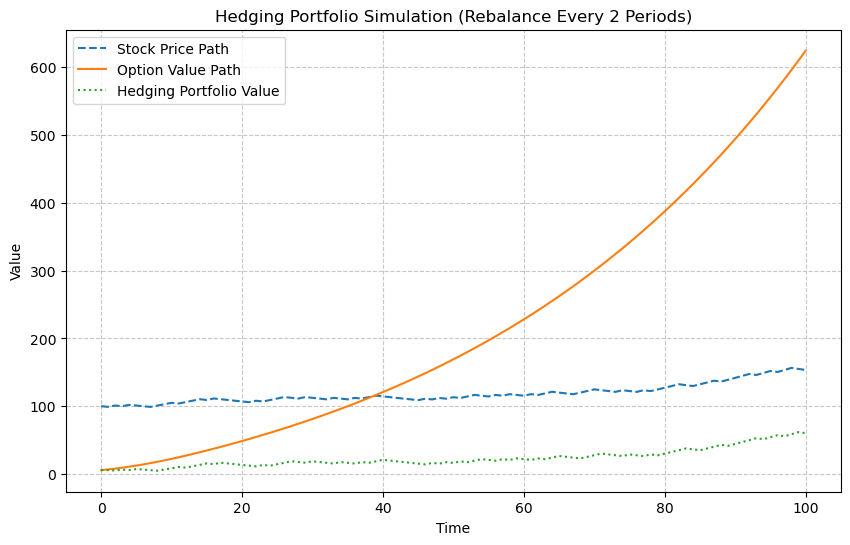

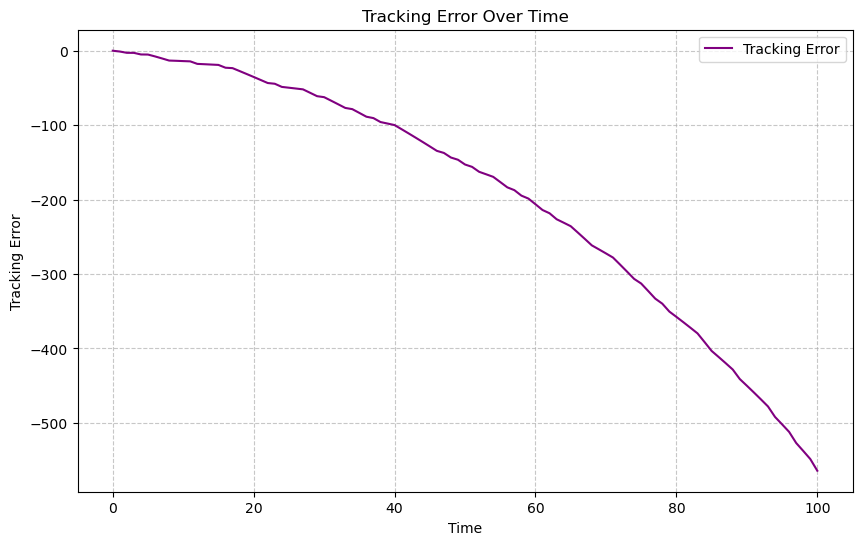

([100,
  99.0,
  100.98,
  99.9702,
  101.969604,
  100.94990796,
  99.9404088804,
  98.941004791596,
  100.91982488742792,
  102.93822138517648,
  104.99698581288001,
  103.94701595475121,
  106.02595627384623,
  108.14647539932317,
  110.30940490730963,
  109.20631085823653,
  111.39043707540127,
  110.27653270464725,
  109.17376737760078,
  108.08202970382477,
  107.00120940678653,
  105.93119731271867,
  108.04982125897304,
  106.96932304638331,
  109.10870950731098,
  111.2908836974572,
  113.51670137140636,
  112.38153435769229,
  111.25771901411537,
  113.48287339439767,
  112.3480446604537,
  111.22456421384916,
  110.11231857171067,
  112.31456494314489,
  111.19141929371344,
  110.0795051007763,
  112.28109520279183,
  111.15828425076391,
  113.38144993577919,
  115.64907893449477,
  114.49258814514982,
  113.34766226369833,
  112.21418564106133,
  111.09204378465073,
  109.98112334680422,
  108.88131211333618,
  111.0589383556029,
  109.94834897204687,
  112.14731595148781,


In [4]:
hedging_portfolio_simulation(T, S, Ru, Rd, K, rebalance_period=2)